In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
PREFIX = "/data/analytics/catch_bonds/1sq0/dists_max_chains"
mean_dist_dict = defaultdict(list)
std_dist_dict = defaultdict(list)

for rep in range(1, 11):
    for force in np.arange(0, 2.1, .1):
        force_str = str(int(force)) if force == int(force) else str(force)
        dists_df = pd.read_csv("{}/{}_{}.xvg".format(PREFIX, rep, force_str), skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "max_dist"]
        
        mean_dist_dict[int(force * 10)].append(dists_df.max_dist.mean())
        std_dist_dict[int(force * 10)].append(dists_df.max_dist.std())

Text(0,0.5,'Mean maximum distance')

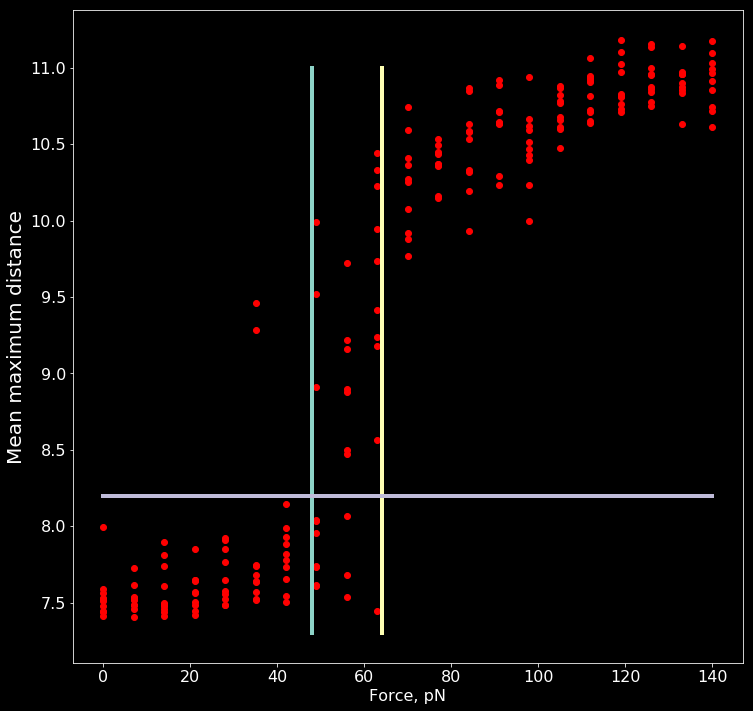

In [3]:
fig = plt.figure(figsize=(12, 12))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
ax = fig.add_subplot(1, 1, 1)

for k, v in mean_dist_dict.items():
    ax.plot([k * 7] * len(v), v, "ro")
    
ax.plot([48, 48], [7.3, 11], linewidth=4)
ax.plot([64, 64], [7.3, 11], linewidth=4)
ax.plot([0, 140], [8.2, 8.2], linewidth=4)
    
[t.set_fontsize(16) for t in ax.get_xticklabels()]
ax.set_xlabel("Force, pN", fontdict={"size": 16})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
ax.set_ylabel("Mean maximum distance", fontdict={"size": 20})

Let's assume that Mean Maximum Distance (MMD) >= 83 angstrom means that two proteins are dissociated  
It means that under 63pN force there is only one associated complex  
We can compare contacts between it and other complexes under the same force  
Let's try to find contacts presented in the associated complex and not presented in any dissociated one

In [4]:
MAX_DIST = 0.3
MIN_OCCUPANCY = 0.1
CRITICAL_MMD = 8.3
FIRST_CHAIN = 198

In [5]:
def get_pair(num, first_chain_len=FIRST_CHAIN):
    f = num % first_chain_len
    s = num // first_chain_len
    return (f + 1, s + 1)

In [6]:
whole_arr = np.load("/data/analytics/catch_bonds/1sq0/dists_npz/whole.npz")["arr_0"]

Let's try to find all contacts presented in **every** associated structure and not presented in **at least one** disassociated structure. This procedure repeated for three levels of force: 49, 56 and 63 pN.

In [7]:
force_pairs_dict = dict()

for force in [0.9, 0.8, 0.7]:
    print(force)
    assoc_reps = np.where(np.array(mean_dist_dict[int(force * 10)]) < CRITICAL_MMD)[0]
    disassoc_reps = np.where(np.array(mean_dist_dict[int(force * 10)]) > CRITICAL_MMD)[0]
    
    assoc_contacts = None
    for r in assoc_reps:
        contact_matrix = (whole_arr[r, int(force*10), :, :] < MAX_DIST).mean(axis=0) > MIN_OCCUPANCY
        cur_contacts = set(np.where(contact_matrix)[0])
        if assoc_contacts is None:
            assoc_contacts = cur_contacts
            continue
        assoc_contacts.intersection_update(cur_contacts)

    disassoc_contacts = None
    for r in disassoc_reps:
        contact_matrix = (whole_arr[r, int(force*10), :, :] < MAX_DIST).mean(axis=0) > MIN_OCCUPANCY
        cur_contacts = set(np.where(contact_matrix)[0])
        if disassoc_contacts is None:
            disassoc_contacts = cur_contacts
            continue
        disassoc_contacts.intersection_update(cur_contacts)

    assoc_contacts.difference_update(disassoc_contacts)
        
    assoc_pairs = [get_pair(i) for i in assoc_contacts]
    force_pairs_dict[force] = [(p[0] + 1268, p[1]) for p in assoc_pairs]

0.9
0.8
0.7


We consider only those pairs that are presented in every level of force:

In [8]:
intersection = None

for k, v in force_pairs_dict.items():
    if intersection is None:
        intersection = set(v)
        continue

    intersection.intersection_update(v)
intersection

{(1359, 241), (1367, 152), (1367, 176)}